# PyTorch CIFAR-10 local training  

## Prerequisites

This notebook shows how to use the SageMaker Python SDK to run your code in a local container before deploying to SageMaker's managed training or hosting environments.  This can speed up iterative testing and debugging while using the same familiar Python SDK interface.  Just change your estimator's `instance_type` to `local` (or `local_gpu` if you're using an ml.p2 or ml.p3 notebook instance).

In order to use this feature, you'll need to install docker-compose (and nvidia-docker if training with a GPU).

**Note: you can only run a single local notebook at one time.**

In [1]:
!/bin/bash ./setup.sh

The user has root access.
nvidia-docker2 already installed. We are good to go!
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


## Overview

The **SageMaker Python SDK** helps you deploy your models for training and hosting in optimized, productions ready containers in SageMaker. The SageMaker Python SDK is easy to use, modular, extensible and compatible with TensorFlow, MXNet, PyTorch. This tutorial focuses on how to create a convolutional neural network model to train the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) using **PyTorch in local mode**.

### Set up the environment

This notebook was created and tested on a single ml.p2.xlarge notebook instance.

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cnn-cifar10"

role = sagemaker.get_execution_role()

In [3]:
import os
import subprocess

instance_type = "local"

try:
    if subprocess.call("nvidia-smi") == 0:
        ## Set type to GPU if one is present
        instance_type = "local_gpu"
except:
    pass

print("Instance type = " + instance_type)

Instance type = local_gpu


### Download the CIFAR-10 dataset

In [4]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


### Data Preview

     ship      deer      frog      frog


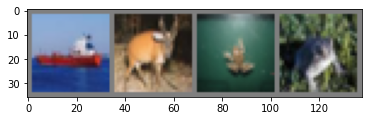

In [5]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

### Upload the data
We use the ```sagemaker.Session.upload_data``` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use this later when we start the training job.

In [6]:
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix="data/cifar10")

# Construct a script for training 
Here is the full code for the network model:

In [7]:
# !pygmentize source/cifar10.py

## Script Functions

SageMaker invokes the main function defined within your training script for training. When deploying your trained model to an endpoint, the model_fn() is called to determine how to load your trained model. The model_fn() along with a few other functions list below are called to enable predictions on SageMaker.

### [Predicting Functions](https://github.com/aws/sagemaker-pytorch-containers/blob/master/src/sagemaker_pytorch_container/serving.py)
* model_fn(model_dir) - loads your model.
* input_fn(serialized_input_data, content_type) - deserializes predictions to predict_fn.
* output_fn(prediction_output, accept) - serializes predictions from predict_fn.
* predict_fn(input_data, model) - calls a model on data deserialized in input_fn.

The model_fn() is the only function that doesn't have a default implementation and is required by the user for using PyTorch on SageMaker. 

## Create a training job using the sagemaker.PyTorch estimator

The `PyTorch` class allows us to run our training function on SageMaker. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. For local training with GPU, we could set this to "local_gpu".  In this case, `instance_type` was set above based on your whether you're running a GPU instance.

After we've constructed our `PyTorch` object, we fit it using the data we uploaded to S3. Even though we're in local mode, using S3 as our data source makes sense because it maintains consistency with how SageMaker's distributed, managed training ingests data.


In [8]:
from sagemaker.pytorch import PyTorch

cifar10_estimator = PyTorch(
    entry_point="source/cifar10.py",
    role=role,
    framework_version="1.7.1",
    py_version='py3',
    instance_count=1,
    instance_type=instance_type,
)

cifar10_estimator.fit('file://./data/')
#cifar10_estimator.fit(inputs)

Creating 09u8fdtmoh-algo-1-100m5 ... 
Creating 09u8fdtmoh-algo-1-100m5 ... done
Attaching to 09u8fdtmoh-algo-1-100m5
09u8fdtmoh-algo-1-100m5 | 2021-05-26 08:57:22,193 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
09u8fdtmoh-algo-1-100m5 | 2021-05-26 08:57:22,236 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
09u8fdtmoh-algo-1-100m5 | 2021-05-26 08:57:22,239 sagemaker_pytorch_container.training INFO     Invoking user training script.
09u8fdtmoh-algo-1-100m5 | 2021-05-26 08:57:22,522 sagemaker-training-toolkit INFO     Invoking user script
09u8fdtmoh-algo-1-100m5 | 
09u8fdtmoh-algo-1-100m5 | Training Env:
09u8fdtmoh-algo-1-100m5 | 
09u8fdtmoh-algo-1-100m5 | {
09u8fdtmoh-algo-1-100m5 |     "additional_framework_parameters": {},
09u8fdtmoh-algo-1-100m5 |     "channel_input_dirs": {
09u8fdtmoh-algo-1-100m5 |         "training": "/opt/ml/input/data/training"
09u8fdtmoh-algo-1-100m5 |     },
09u8fdtmoh-algo

## 모델 아티펙트 다운로드 및 압축해제

In [ ]:
model_artifact = cifar10_estimator.model_data
print("model_artifact: ", model_artifact)

In [ ]:
import os

model_data_dir = 'model'
os.makedirs(model_data_dir, exist_ok=True)


In [ ]:
%%sh -s {model_artifact} {model_data_dir}

echo $1
echo $2

aws s3 cp $1 $2
cd $2
tar -xvf model.tar.gz  

In [ ]:
# model_dir = os.path.join(model_data_dir, "model.pth")
# print("model_dir: ", model_dir)

##  내부 테스트

In [ ]:
import torch.nn as nn
#https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py#L118
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [ ]:
import logging, sys
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def model_fn(model_dir):
    logger.info("--> model_dir : {}".format(model_dir))
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Net()
    if torch.cuda.device_count() > 1:
        logger.info("Gpu count: {}".format(torch.cuda.device_count()))
        model = nn.DataParallel(model)
        
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
        
    return model.to(device)

In [ ]:
model_fn(model_data_dir)

# Deploy the trained model to prepare for predictions

The deploy() method creates an endpoint (in this case locally) which serves prediction requests in real-time.

In [ ]:
from sagemaker.pytorch import PyTorchModel

cifar10_predictor = cifar10_estimator.deploy(initial_instance_count=1, instance_type=instance_type)

# Invoking the endpoint

In [ ]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

# Clean-up

Deleting the local endpoint when you're finished is important, since you can only run one local endpoint at a time.

In [ ]:
# cifar10_estimator.delete_endpoint()